# FOD-A Dataset Analysis (Fixed Version)

This notebook analyzes the FOD-A dataset with support for floating-point coordinates.

In [1]:
import os
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter
import seaborn as sns
from pathlib import Path

# Set the path to your FOD-A dataset
DATASET_PATH = Path("../data/raw/fod_a_data/VOC2007")
print(f"Dataset path: {DATASET_PATH}")
print(f"Dataset exists: {DATASET_PATH.exists()}")

Dataset path: ../data/raw/fod_a_data/VOC2007
Dataset exists: True


In [2]:
# Parse Pascal VOC annotations with support for floating-point coordinates
def parse_voc_annotation(xml_file):
    """Parse Pascal VOC XML annotation file with support for float coordinates"""
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    # Get image info
    filename = root.find('filename').text
    size = root.find('size')
    width = int(float(size.find('width').text))  # Handle float values
    height = int(float(size.find('height').text))  # Handle float values
    
    # Get all objects
    objects = []
    for obj in root.findall('object'):
        try:
            obj_info = {
                'name': obj.find('name').text,
                'difficult': int(obj.find('difficult').text if obj.find('difficult') is not None else 0)
            }
            
            # Get bounding box with float support
            bbox = obj.find('bndbox')
            obj_info['bbox'] = {
                'xmin': int(float(bbox.find('xmin').text)),
                'ymin': int(float(bbox.find('ymin').text)),
                'xmax': int(float(bbox.find('xmax').text)),
                'ymax': int(float(bbox.find('ymax').text))
            }
            
            # Validate bounding box
            if (obj_info['bbox']['xmax'] <= obj_info['bbox']['xmin'] or 
                obj_info['bbox']['ymax'] <= obj_info['bbox']['ymin']):
                continue
            
            objects.append(obj_info)
        except (ValueError, AttributeError) as e:
            print(f"Warning: Error parsing object in {xml_file}: {e}")
            continue
    
    return {
        'filename': filename,
        'width': width,
        'height': height,
        'objects': objects
    }

In [4]:
# Analyze the dataset
def analyze_dataset(dataset_path, max_files=1000):
    """Analyze the FOD-A dataset with error handling"""
    annotations_dir = dataset_path / "Annotations"
    images_dir = dataset_path / "JPEGImages"
    
    print(f"Annotations directory: {annotations_dir}")
    print(f"Images directory: {images_dir}")
    
    # Initialize statistics
    class_counts = Counter()
    bbox_sizes = []
    image_sizes = []
    objects_per_image = []
    error_count = 0
    processed_count = 0
    
    # Process all annotation files
    xml_files = list(annotations_dir.glob("*.xml"))
    print(f"Found {len(xml_files)} annotation files")
    
    # Limit the number of files to process for speed
    xml_files = xml_files[:max_files]
    print(f"Processing first {len(xml_files)} files...")
    
    for i, xml_file in enumerate(xml_files):
        if i % 100 == 0:
            print(f"Progress: {i}/{len(xml_files)} files processed")
            
        try:
            annotation = parse_voc_annotation(xml_file)
            
            # Skip files with no valid objects
            if not annotation['objects']:
                continue
                
            processed_count += 1
            
            # Count objects per image
            objects_per_image.append(len(annotation['objects']))
            
            # Store image size
            image_sizes.append((annotation['width'], annotation['height']))
            
            # Process each object
            for obj in annotation['objects']:
                class_counts[obj['name']] += 1
                
                # Calculate bbox size
                bbox = obj['bbox']
                width = bbox['xmax'] - bbox['xmin']
                height = bbox['ymax'] - bbox['ymin']
                bbox_sizes.append((width, height))
                
        except Exception as e:
            error_count += 1
            if error_count <= 5:  # Only print first 5 errors
                print(f"Error processing {xml_file}: {e}")
            elif error_count == 6:
                print("... (suppressing further error messages)")
    
    print(f"\nProcessing complete!")
    print(f"Successfully processed: {processed_count} files")
    print(f"Errors encountered: {error_count} files")
    
    return {
        'class_counts': class_counts,
        'bbox_sizes': bbox_sizes,
        'image_sizes': image_sizes,
        'objects_per_image': objects_per_image,
        'processed_count': processed_count,
        'error_count': error_count
    }

# Run analysis on first 1000 files for speed
stats = analyze_dataset(DATASET_PATH, max_files=35000)
print("\nDataset Analysis Complete!")

Annotations directory: ../data/raw/fod_a_data/VOC2007/Annotations
Images directory: ../data/raw/fod_a_data/VOC2007/JPEGImages
Found 33793 annotation files
Processing first 33793 files...
Progress: 0/33793 files processed
Progress: 100/33793 files processed
Progress: 200/33793 files processed
Progress: 300/33793 files processed
Progress: 400/33793 files processed
Progress: 500/33793 files processed
Progress: 600/33793 files processed
Progress: 700/33793 files processed
Progress: 800/33793 files processed
Progress: 900/33793 files processed
Progress: 1000/33793 files processed
Progress: 1100/33793 files processed
Progress: 1200/33793 files processed
Progress: 1300/33793 files processed
Progress: 1400/33793 files processed
Progress: 1500/33793 files processed
Progress: 1600/33793 files processed
Progress: 1700/33793 files processed
Progress: 1800/33793 files processed
Progress: 1900/33793 files processed
Progress: 2000/33793 files processed
Progress: 2100/33793 files processed
Progress: 2

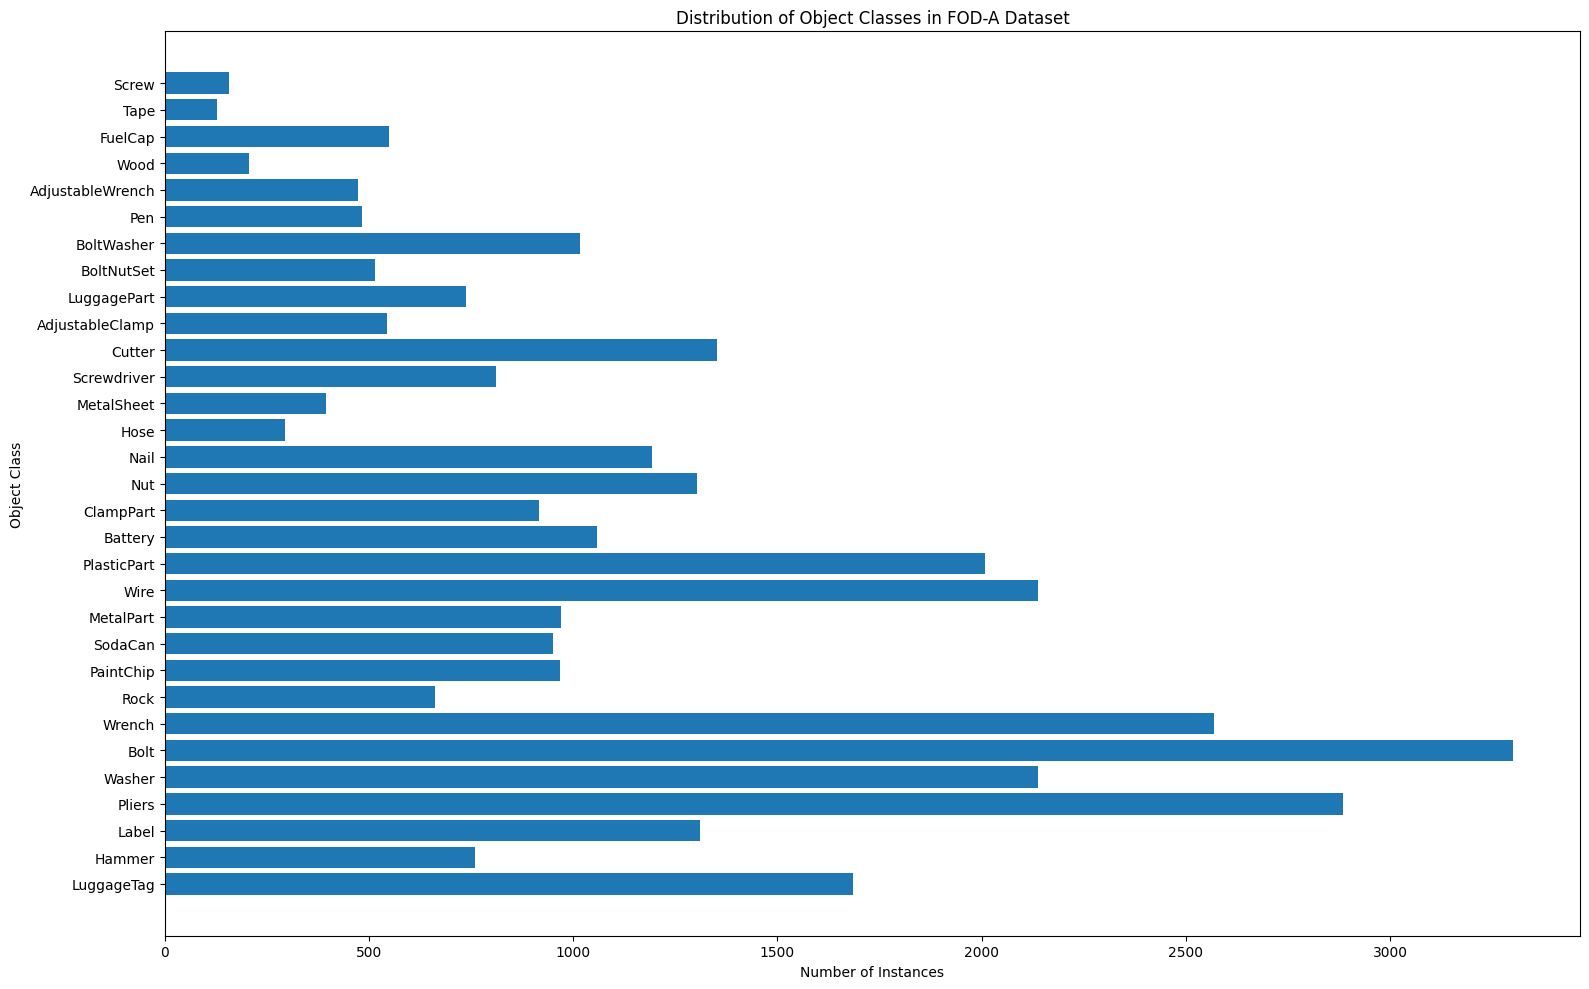

Total classes: 31
Total objects analyzed: 34472
Average objects per class: 1112.00

Top 10 most common classes:
1. Bolt: 3300 instances
2. Pliers: 2884 instances
3. Wrench: 2568 instances
4. Washer: 2139 instances
5. Wire: 2138 instances
6. PlasticPart: 2008 instances
7. LuggageTag: 1686 instances
8. Cutter: 1352 instances
9. Label: 1310 instances
10. Nut: 1303 instances


In [5]:
# Visualize class distribution
plt.figure(figsize=(16, 10))
classes = list(stats['class_counts'].keys())
counts = list(stats['class_counts'].values())

# Create horizontal bar chart for better readability
plt.barh(classes, counts)
plt.xlabel('Number of Instances')
plt.ylabel('Object Class')
plt.title('Distribution of Object Classes in FOD-A Dataset')
plt.tight_layout()
plt.show()

print(f"Total classes: {len(classes)}")
print(f"Total objects analyzed: {sum(counts)}")
print(f"Average objects per class: {np.mean(counts):.2f}")

# Show most common classes
print("\nTop 10 most common classes:")
for i, (cls, count) in enumerate(stats['class_counts'].most_common(10), 1):
    print(f"{i}. {cls}: {count} instances")

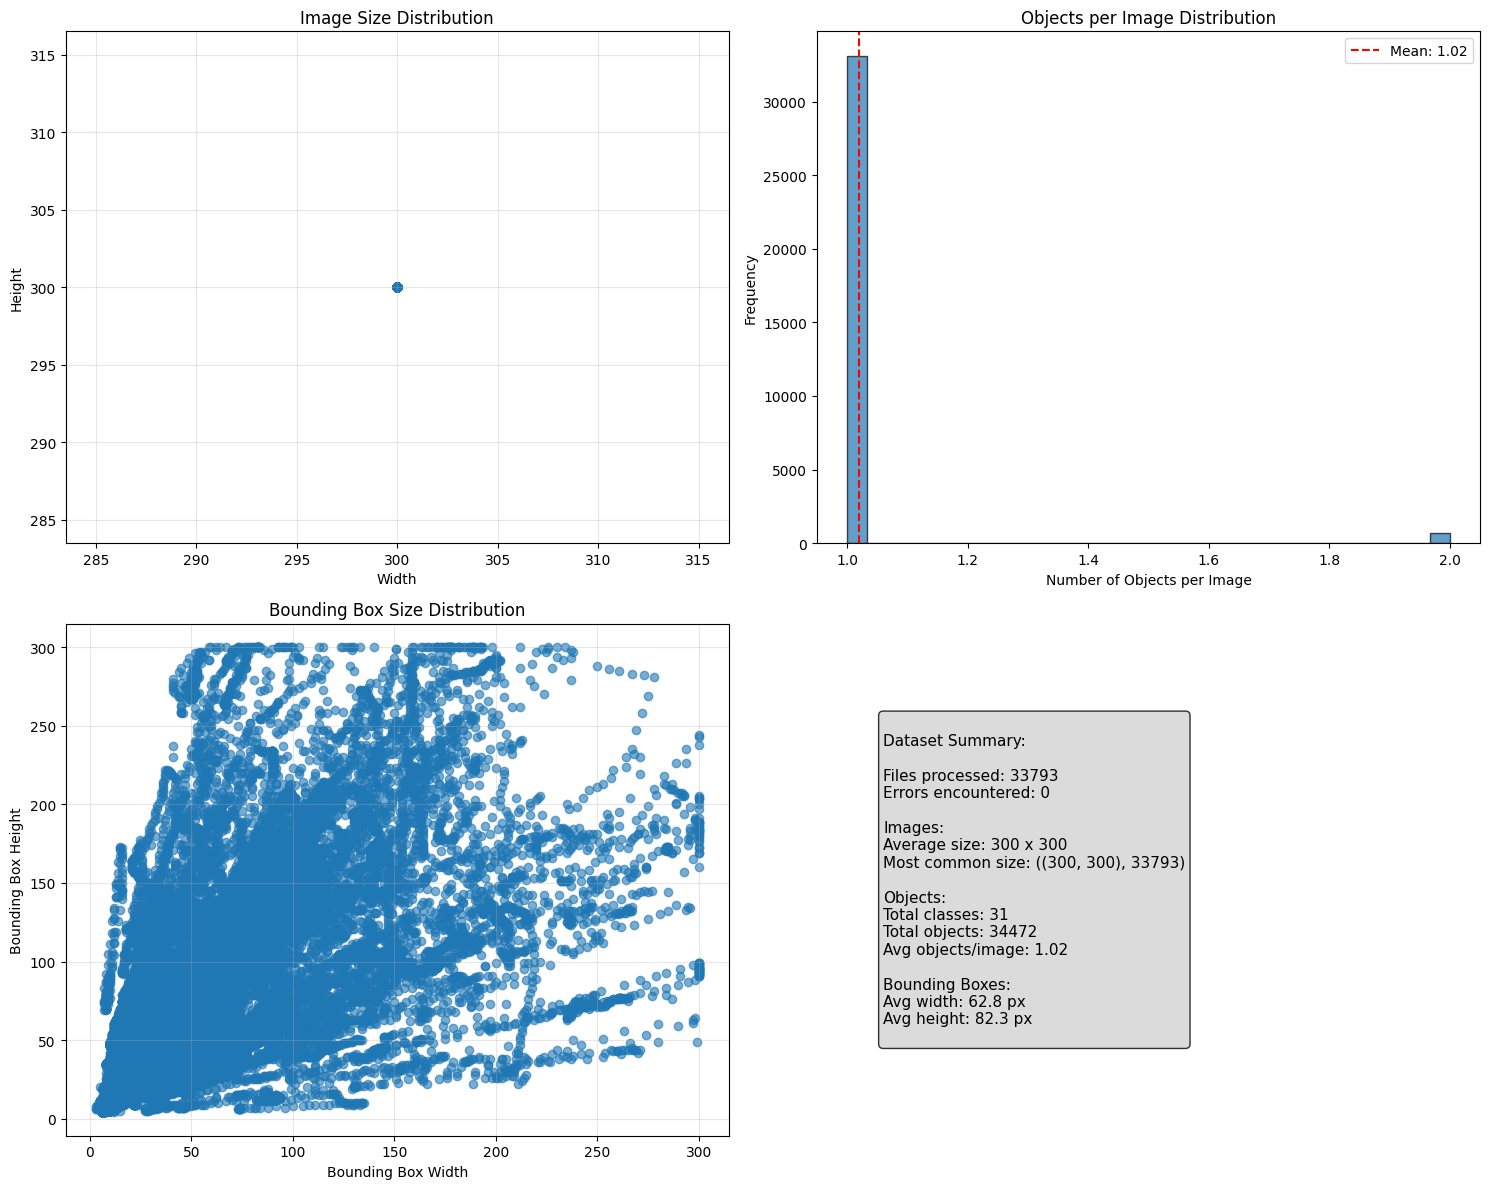

In [6]:
# Visualize image sizes and object distribution
widths = [size[0] for size in stats['image_sizes']]
heights = [size[1] for size in stats['image_sizes']]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Image size scatter plot
ax1.scatter(widths, heights, alpha=0.6)
ax1.set_xlabel('Width')
ax1.set_ylabel('Height')
ax1.set_title('Image Size Distribution')
ax1.grid(True, alpha=0.3)

# Objects per image histogram
ax2.hist(stats['objects_per_image'], bins=30, edgecolor='black', alpha=0.7)
ax2.set_xlabel('Number of Objects per Image')
ax2.set_ylabel('Frequency')
ax2.set_title('Objects per Image Distribution')
ax2.axvline(np.mean(stats['objects_per_image']), color='red', linestyle='--', 
            label=f'Mean: {np.mean(stats["objects_per_image"]):.2f}')
ax2.legend()

# Bounding box sizes
bbox_widths = [size[0] for size in stats['bbox_sizes']]
bbox_heights = [size[1] for size in stats['bbox_sizes']]

ax3.scatter(bbox_widths, bbox_heights, alpha=0.6)
ax3.set_xlabel('Bounding Box Width')
ax3.set_ylabel('Bounding Box Height')
ax3.set_title('Bounding Box Size Distribution')
ax3.grid(True, alpha=0.3)

# Summary statistics
summary_text = f"""
Dataset Summary:

Files processed: {stats['processed_count']}
Errors encountered: {stats['error_count']}

Images:
Average size: {np.mean(widths):.0f} x {np.mean(heights):.0f}
Most common size: {Counter(stats['image_sizes']).most_common(1)[0]}

Objects:
Total classes: {len(classes)}
Total objects: {sum(counts)}
Avg objects/image: {np.mean(stats['objects_per_image']):.2f}

Bounding Boxes:
Avg width: {np.mean(bbox_widths):.1f} px
Avg height: {np.mean(bbox_heights):.1f} px
"""

ax4.text(0.1, 0.5, summary_text, transform=ax4.transAxes,
         fontsize=11, verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
ax4.axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Check for potential issues in the dataset
print("Dataset Quality Check:")
print("=" * 30)

# Check for very small bounding boxes
small_boxes = [(w, h) for w, h in stats['bbox_sizes'] if w < 10 or h < 10]
print(f"Very small bounding boxes (< 10px): {len(small_boxes)} / {len(stats['bbox_sizes'])} ({len(small_boxes)/len(stats['bbox_sizes'])*100:.1f}%)")

# Check for very large bounding boxes
large_boxes = [(w, h) for w, h in stats['bbox_sizes'] if w > 500 or h > 500]
print(f"Very large bounding boxes (> 500px): {len(large_boxes)} / {len(stats['bbox_sizes'])} ({len(large_boxes)/len(stats['bbox_sizes'])*100:.1f}%)")

# Check image size consistency
unique_sizes = len(set(stats['image_sizes']))
print(f"Unique image sizes: {unique_sizes}")
if unique_sizes > 1:
    print("Note: Variable image sizes detected. This is normal for real-world datasets.")

# Check for images with no objects
images_with_no_objects = stats['error_count']
total_processed = stats['processed_count'] + stats['error_count']
print(f"Images with no valid objects: {images_with_no_objects} / {total_processed} ({images_with_no_objects/total_processed*100:.1f}%)")

# Recommend next steps
print("\nRecommendations:")
print("=" * 30)
print("1. Use the fixed voc_to_yolo_converter.py for dataset conversion")
print("2. Consider filtering out bounding boxes smaller than 5px for training")
print("3. The dataset appears suitable for training with proper preprocessing")
print(f"4. Expected YOLO training time: ~{len(stats['class_counts'])} classes")

Dataset Quality Check:
Very small bounding boxes (< 10px): 2868 / 34472 (8.3%)
Very large bounding boxes (> 500px): 0 / 34472 (0.0%)
Unique image sizes: 1
Images with no valid objects: 0 / 33793 (0.0%)

Recommendations:
1. Use the fixed voc_to_yolo_converter.py for dataset conversion
2. Consider filtering out bounding boxes smaller than 5px for training
3. The dataset appears suitable for training with proper preprocessing
4. Expected YOLO training time: ~31 classes
